<a href="https://colab.research.google.com/github/raulbenitez/AMRITA_UPC/blob/main/Caliper_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from PIL import Image
import skimage.measure
import os
import cv2

## **VGG Transfer Learning**

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten

In [2]:
# set image size
img_size = (224, 224)

# load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size+(3,))

# freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [3]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# Add a Flatten layer after the base model output
import tensorflow as tf
d = base_model.output
d = tf.keras.layers.Flatten()(d)
d1 = tf.keras.layers.Dense(256, activation='relu')(d)
d2 = tf.keras.layers.Dense(2, activation='softmax')(d1)
vggmodel = tf.keras.models.Model(inputs=base_model.input, outputs=d2)
vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
ATTRIBUTE = "Caliper"
train_df = pd.read_csv("/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/augmented_train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/augmented_test.csv")

In [14]:
train_df[ATTRIBUTE] = train_df[ATTRIBUTE].apply(str)
val_df[ATTRIBUTE] = val_df[ATTRIBUTE].apply(str)

In [15]:
train_df['filename'] = train_df['filename'].apply(lambda x: x.replace('\\', '/'))
val_df['filename'] = val_df['filename'].apply(lambda x: x.replace('\\', '/'))

In [16]:
val_df

,Image ID,Caliper,filename
0,127,0,Caliper/0/image_127.jpg
1,rotated_86.jpg,1,Caliper/1/rotated_image_86.jpg
2,64,1,Caliper/1/image_64.jpg
3,50,0,Caliper/0/image_50.jpg
4,rotated_106.jpg,0,Caliper/0/rotated_image_106.jpg
...,...,...,...
73,rotated_175.jpg,1,Caliper/1/rotated_image_175.jpg
74,205,1,Caliper/1/image_205.jpg
75,rotated_193.jpg,1,Caliper/1/rotated_image_193.jpg
76,66,1,Caliper/1/image_66.jpg


In [17]:
train_df['filename'] = "/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/" + train_df['filename']
val_df['filename'] = "/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/" +val_df['filename']


In [18]:
val_df.filename[0]

'/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/Caliper/0/image_127.jpg'

In [19]:
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_CLASSES = train_df[ATTRIBUTE].nunique()
TRAIN_RATIO = 0.8

In [20]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = ATTRIBUTE,
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

val_generator = datagen.flow_from_dataframe (
    val_df,
    x_col = "filename",
    y_col = ATTRIBUTE,
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 308 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('caliper_vgg16/{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
vggmodel.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = vggmodel.fit_generator(
    training_generator,
    epochs = 10,
    validation_data = val_generator,
    callbacks = mycallbacks,
    #class_weight=class_weights,
    #initial_epoch=10
)

<ipython-input-47-9122c9a086f1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vggmodel.fit_generator(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


20/20 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.6169 
Epoch 1: val_accuracy improved from -inf to 0.57692, saving model to caliper_vgg16/01_0.620_0.577.h5
20/20 [==============================] - 506s 25s/step - loss: 0.7081 - accuracy: 0.6169 - val_loss: 0.6203 - val_accuracy: 0.5769 - lr: 1.0000e-04
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.7857 
Epoch 2: val_accuracy improved from 0.57692 to 0.62821, saving model to caliper_vgg16/02_0.579_0.628.h5
20/20 [==============================] - 498s 25s/step - loss: 0.4508 - accuracy: 0.7857 - val_loss: 0.5794 - val_accuracy: 0.6282 - lr: 1.0000e-04
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8604 
Epoch 3: val_accuracy improved from 0.62821 to 0.64103, saving model to caliper_vgg16/03_0.688_0.641.h5
20/20 [==============================] - 495s 25s/step - loss: 0.3374 - accuracy: 0.8604 - val_loss: 0.6882 - val_accurac

# **VGG16-GradCAM**

In [21]:
vggmodel.load_weights('/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/24_0.502_0.897.h5')

In [14]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [15]:
@tf.function
def compute_gradcam_map(model, image, eps=1e-8):
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(get_last_layer_name(model)).output, model.output]
    )
    gradModel.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        convOutputs, predictions = gradModel(input_image, training=False)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    grads = tape.gradient(loss, convOutputs)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    convOutputs = convOutputs[0]
    heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.image.resize(heatmap[tf.newaxis, ..., tf.newaxis], [IMG_SIZE, IMG_SIZE])
    heatmap = tf.squeeze(heatmap)

    heatmap = normalize(heatmap)
    return heatmap

In [16]:
@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []
#     return model.get_layer(index=47).name

In [17]:
@tf.function
def generate_gradcam(img, label, global_model):
    fused_heatmap = compute_gradcam_map(global_model, img)
    return fused_heatmap

In [18]:
@tf.function
def generate_gradcam_batch(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)   
    return fused_heatmaps

In [55]:
def overlay_heatmap(image, heatmap, alpha=0.7,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

In [79]:
# Generate a new generator with a smaller batch size to visualize the gradcams
new_training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = ATTRIBUTE,
    batch_size = 6,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)


Found 308 validated image filenames belonging to 2 classes.


In [80]:
images, labels = new_training_generator.next()

In [81]:
print("True labels: ", tf.argmax(labels, axis = 1).numpy())
print("Predictions: ", tf.argmax(vggmodel(images), axis=1).numpy())

True labels:  [0 1 0 1 1 0]
Predictions:  [0 1 0 1 1 0]


In [82]:
training_generator.class_indices

{'0': 0, '1': 1}

In [83]:
%%time
heatmaps = generate_gradcam_batch(images, vggmodel, 0.5)

CPU times: user 15.8 s, sys: 666 ms, total: 16.5 s
Wall time: 10.8 s


In [84]:
overlayed_images = [overlay_heatmap(img, hmap.numpy()) for (img, hmap) in zip(images, heatmaps)]

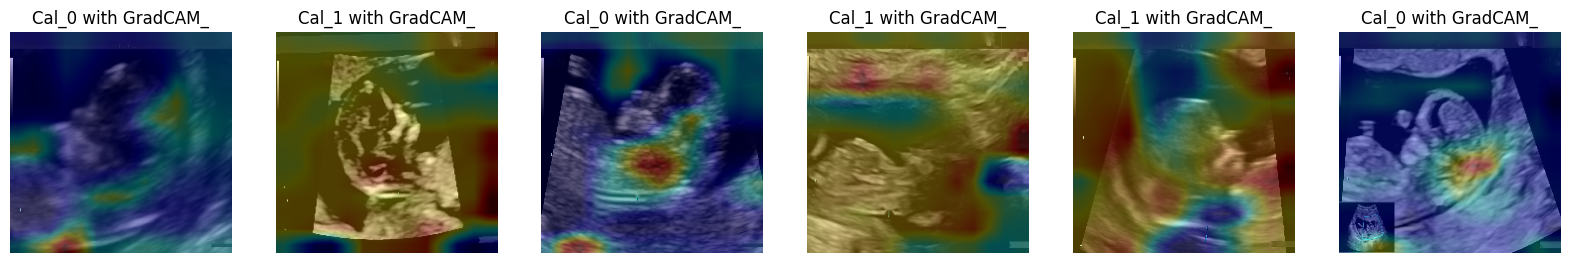

In [85]:
# Display the overlayed images with titles
fig, axs = plt.subplots(1, len(overlayed_images), figsize=(20, 5))
for i, overlayed_image in enumerate(overlayed_images):
  if np.argmax(labels[i])==1:
      label= 'Cal_1'
  else:
      label='Cal_0'
  
  axs[i].imshow(overlayed_image)
  axs[i].set_title( label+  ' with GradCAM_')
  for a in axs:
    a.axis('off') 
plt.show()

## **Save Overlayed Gradcams**

In [86]:
outputpath = '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/grad_vgg16'
gradcams_dir = os.path.join(outputpath, 'gradcams')
os.makedirs(gradcams_dir, exist_ok=True)

for i, overlayed_image in enumerate(overlayed_images):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(overlayed_image)
    ax.axis('off')
    img_path = os.path.join(gradcams_dir, f"{i+22}_{label}.jpg")
    plt.axis('tight')
    plt.savefig(img_path)
    plt.close(fig)


In [45]:
img_path

'/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/grad_vgg16/gradcams/5_Cal_0.jpg'

## **Cumulative GradCam**

In [87]:
from PIL import Image
from skimage.transform import resize

In [88]:
def read_image(file_path):
    img = np.asarray(Image.open(file_path))/255.
    img = resize(image=img, output_shape=(IMG_SIZE, IMG_SIZE, 3))
    return img

In [100]:
import os
IMG_SIZE=224
img_height=224
img_width=224
image_paths_name='/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1'
image_names= os.listdir(image_paths_name)
image_paths = [os.path.join(image_paths_name, name) for name in image_names]
image_paths

['/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_19.jpg',
 '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_11.jpg',
 '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_66.jpg',
 '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_6.jpg',
 '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_63.jpg',
 '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_5.jpg',
 '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_67.jpg',
 '/content/drive/MyDrive/MY_Learnings/UPC-Ultrasound/Caliper_Binary_classification/cumulative_test/label1/image_111.jpg',
 '/content/drive/MyDrive/MY_Learn

In [101]:
BATCH_SIZE=10
def find_cumulative_gradcams(image_paths):
    cum_gradcam = tf.zeros((IMG_SIZE, IMG_SIZE))
    for i in range(len(image_paths)//BATCH_SIZE + 1):
        print(i)
        img_batch = image_paths[BATCH_SIZE * i: BATCH_SIZE * (i+1)]
        imgs = [read_image(path) for path in img_batch]
        gradcams_batch = generate_gradcam_batch(imgs,vggmodel,0.1)
        cum_gradcam += tf.reduce_sum(gradcams_batch, axis=0)
        
    return normalize(cum_gradcam)

In [102]:
import numpy as np
tf.config.run_functions_eagerly(True)
cum_gdcam = find_cumulative_gradcams(image_paths)

0
1


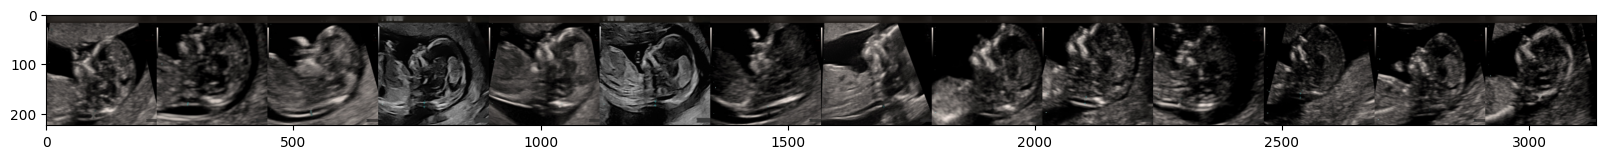

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack([read_image(path) for path in image_paths]))

Text(0.5, 1.0, 'Class 1')

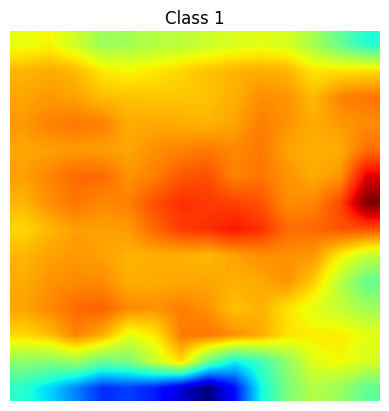

In [104]:
import matplotlib.pyplot as plt
plt.imshow(cum_gdcam, cmap='jet')
plt.axis('off')
plt.title('Class 1')

Text(0.5, 1.0, 'Class 0')

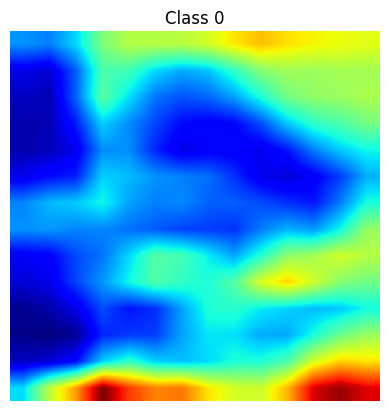

In [95]:
import matplotlib.pyplot as plt
plt.imshow(cum_gdcam, cmap='jet')
plt.axis('off')
plt.title('Class 0')

In [107]:
import cv2
def overlay_heatmap(image, heatmap, alpha=0.5,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

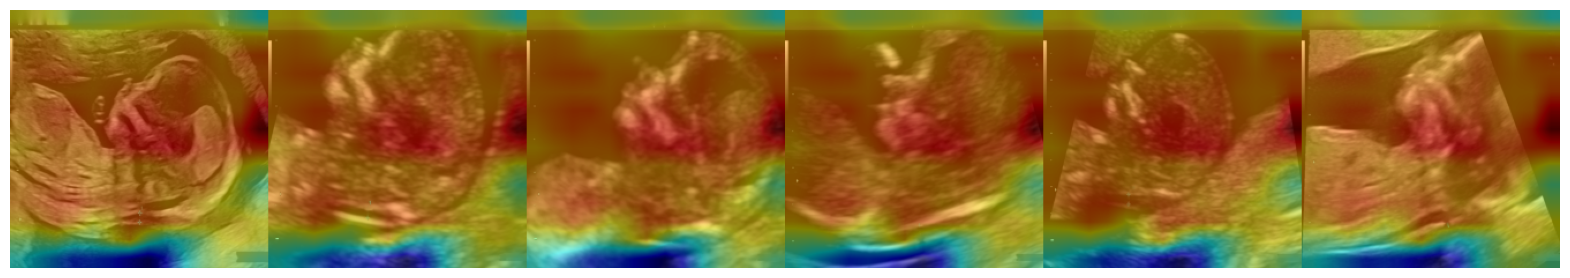

In [108]:
#Display random 6 images
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
random_indices = random.sample(range(len(image_paths)), 6)  # Select 6 random indices
images = [overlay_heatmap(read_image(image_paths[i]), cum_gdcam.numpy()) for i in random_indices]

plt.imshow(np.hstack(images))
plt.axis('off')
plt.show()

# **GradCam++**

In [22]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []

@tf.function
def grad_cam_plus(model, img,
                  layer_name=get_last_layer_name(vggmodel), label_name=None,
                  category_id=None):
    """Get a heatmap by Grad-CAM++.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name is not None:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
       max_heat = 1e-10
    heatmap /= max_heat
    #heatmap=normalize(grad_cam_map)
    return heatmap
@tf.function
def generate_gradcamplus_batch(imgs, global_model):

    fused_heatmaps = []
    for image in imgs:
        heatmap = grad_cam_plus(global_model,image)
        fused_heatmaps.append(heatmap )

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)  
    return fused_heatmaps 

In [28]:
# Generate a new generator with a smaller batch size to visualize the gradcams
new_training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = ATTRIBUTE,
    batch_size = 6,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 308 validated image filenames belonging to 2 classes.


In [29]:
images, labels = new_training_generator.next()

In [30]:
import numpy as np
tf.config.run_functions_eagerly(True)
gradcamplus = generate_gradcamplus_batch(images, vggmodel)

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
alpha=0.5
# Assuming gradcam is a list of GradCAM heatmaps for the images in train_generator
# images is a batch of images from train_generator
#images, y = new_test_generator.next()

# Overlay GradCAM heatmaps on images
overlayed_images = []
for i in range(len(images)):
    # Normalize the heatmap to have values between 0 and 1
    heatmap = gradcamplus [i]
    #heatmap = heatmap - np.min(heatmap)     heatmap = heatmap / np.max(heatmap)     heatmap = np.uint8(255 * heatmap)     heatmap = cv2.resize(heatmap, (images[i].shape[1], images[i].shape[0])) heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #heatmap = (heatmap * 255.).astype('uint8')
    #images[i] = images[i] / 255.0
    heatmap = heatmap - np.min(heatmap) 
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (images[i].shape[1], images[i].shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #overlayed_image=heatmap * 0.5 + images[i]
    #overlayed_image = np.clip(overlayed_image, 0, 255).astype("uint8")
    #overlayed_image = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)
    #overlayed_image = Image.fromarray(overlayed_image)
    # Overlay the heatmap on the original image using alpha blending
    overlayed_image=cv2.addWeighted((images[i].squeeze() * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    #overlayed_image = cv2.addWeighted(images[i].astype(np.uint8), 0.3, heatmap.astype(np.uint8), 0.7, 0)
    overlayed_images.append( overlayed_image)



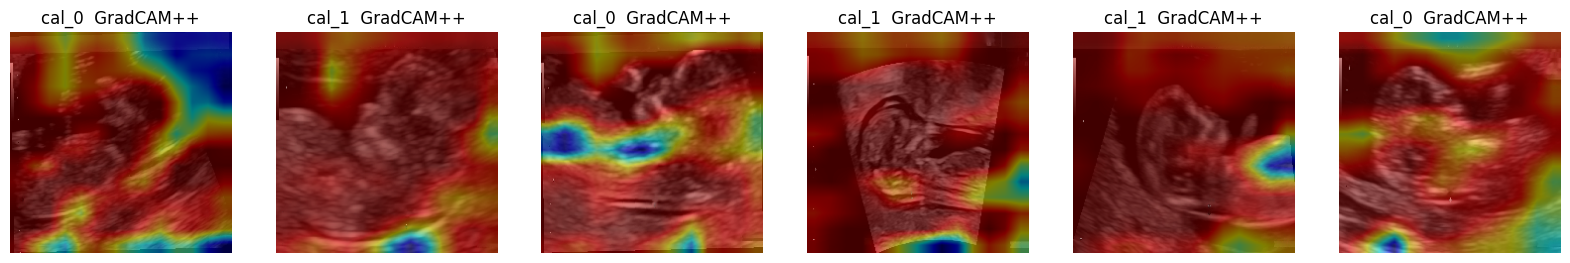

In [32]:
# Display the overlayed images with titles
fig, axs = plt.subplots(1, len(overlayed_images), figsize=(20, 5))
for i, overlayed_image in enumerate(overlayed_images):
  if np.argmax(labels[i])==1:
      label= 'cal_1'
  else:
      label='cal_0'
  
  axs[i].imshow(overlayed_image)
  axs[i].set_title( label + '  GradCAM++')
  for a in axs:
    a.axis('off') 
plt.show()